In [ ]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "./gdrive/My Drive/Assignment 5 Dataset.zip"

In [0]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
from mlxtend.plotting import plot_confusion_matrix

In [0]:
data_dir = r"/content/Assignment 5 Dataset"


In [4]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()
                                      #  transforms.Normalize([0.485, 0.456, 0.406],
                                      #                       [0.229, 0.224, 0.225])])
])
valid_transforms = transforms.Compose([
                                      transforms.Resize((224,224)),
                                      transforms.ToTensor()
                                      # transforms.Normalize([0.485, 0.456, 0.406],
                                      #                      [0.229, 0.224, 0.225])])
])
test_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor()
                                      # transforms.Normalize([0.485, 0.456, 0.406],
                                      #                      [0.229, 0.224, 0.225])])
])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)


#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=True, num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


In [0]:

def corona(model, trainloader, validloader, Epochs, name):
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.train()
    train_acc = []
    valid_acc = []
    pred = []
    accu = 0.0
    train_acc = []
    history = []
    for epoch in range(Epochs):  # loop over the dataset multiple times
        total_train = 0
        train_loss = 0.0
        valid_loss = 0.0
        correct_train = 0
        running_loss = 0.0
        valid_loss = 0.0
        running_corrects = 0.0
        correct = 0
        total = 0
        vcorrect = 0
        train_acc = 0
        valid_acc = 0
        vtotal = 0
        pbar = tqdm(enumerate(trainloader))
        for i, data in pbar:
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(inputs)               #----> forward pass
            loss = criterion(outputs, labels)   #----> compute loss
            loss.backward()                     #----> backward pass
            optimizer.step()                    #----> weights update

            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            running_loss += loss.item()
            

        for i, data in tqdm(enumerate(validloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)               #----> forward pass
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            vcorrect += (predicted == labels).sum().item()
            vtotal += labels.size(0)

        train_loss = running_loss / len(trainloader)
        valid_loss = valid_loss / len(validloader)
        train_acc = correct / total
        valid_acc = vcorrect / vtotal

        history.append([train_loss, valid_loss, train_acc, valid_acc])
        # history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

        print('Epoch #', epoch, '\t\tTraining loss: ', train_loss, '\t Validation loss: ', valid_loss)
        print('\t\tTraining Accuracy: ', 100 * train_acc, '\t Validation Accuracy: ', 100 * valid_acc)
    history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])

    
    torch.save(model.state_dict(), name)
    
    return model, history



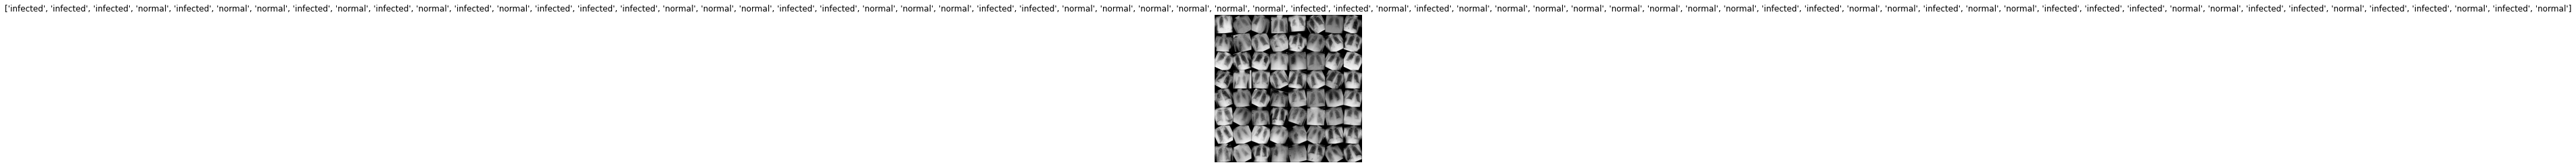

In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
len(train_data)

12000

# Task1 starts here

# Working for VGG here

In [0]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
print(vgg16.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [0]:
vgg16.classifier[0].out_features = 770
vgg16.classifier[3].in_features = 770
vgg16.classifier[3].out_features = 2
# vgg16.classifier[4] = nn.Softmax(dim=1)

In [0]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-3] # Remove last layer
print(features)

[Linear(in_features=25088, out_features=770, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=770, out_features=2, bias=True)]


In [0]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:

for param in vgg16.features.parameters():
    param.requires_grad = False

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

In [0]:
model, history = corona(vgg16, trainloader, validloader, Epochs = 20, name = 'vgg16_FC_Only.pth')

188it [03:48,  1.21s/it]
24it [00:22,  1.07it/s]

Epoch # 0 		Training loss:  0.5075678750079997 	 Validation loss:  0.444806224356095
		Training Accuracy:  82.45833333333333 	 Validation Accuracy:  84.46666666666667



188it [03:38,  1.16s/it]
24it [00:20,  1.16it/s]

Epoch # 1 		Training loss:  0.3236614216039789 	 Validation loss:  0.3805631585419178
		Training Accuracy:  87.58333333333333 	 Validation Accuracy:  85.13333333333334



188it [03:31,  1.13s/it]
24it [00:20,  1.16it/s]

Epoch # 2 		Training loss:  0.30749562961306975 	 Validation loss:  0.3956195153295994
		Training Accuracy:  88.24166666666666 	 Validation Accuracy:  84.93333333333334



188it [03:31,  1.13s/it]
24it [00:20,  1.17it/s]

Epoch # 3 		Training loss:  0.29283371528095387 	 Validation loss:  0.3472981055577596
		Training Accuracy:  88.73333333333333 	 Validation Accuracy:  86.4



188it [03:30,  1.12s/it]
24it [00:20,  1.16it/s]

Epoch # 4 		Training loss:  0.2762441300648324 	 Validation loss:  0.3389114085584879
		Training Accuracy:  89.275 	 Validation Accuracy:  86.0



188it [03:31,  1.13s/it]
24it [00:20,  1.16it/s]

Epoch # 5 		Training loss:  0.2786332475853727 	 Validation loss:  0.3555071782320738
		Training Accuracy:  89.35833333333333 	 Validation Accuracy:  86.0



188it [03:37,  1.16s/it]
24it [00:21,  1.13it/s]

Epoch # 6 		Training loss:  0.2729659776421303 	 Validation loss:  0.34798186520735425
		Training Accuracy:  89.625 	 Validation Accuracy:  85.53333333333333



188it [03:37,  1.16s/it]
24it [00:20,  1.15it/s]

Epoch # 7 		Training loss:  0.27102688977375944 	 Validation loss:  0.3419806944827239
		Training Accuracy:  89.41666666666667 	 Validation Accuracy:  87.0



188it [03:35,  1.14s/it]
24it [00:20,  1.16it/s]

Epoch # 8 		Training loss:  0.26456761558322195 	 Validation loss:  0.3204702747364839
		Training Accuracy:  89.86666666666666 	 Validation Accuracy:  86.73333333333333



188it [03:32,  1.13s/it]
24it [00:20,  1.16it/s]

Epoch # 9 		Training loss:  0.2591077943748616 	 Validation loss:  0.37655882226924103
		Training Accuracy:  90.05833333333332 	 Validation Accuracy:  85.06666666666666



188it [03:30,  1.12s/it]
24it [00:20,  1.16it/s]

Epoch # 10 		Training loss:  0.2671614450977204 	 Validation loss:  0.36101765371859074
		Training Accuracy:  89.79166666666667 	 Validation Accuracy:  85.6



188it [03:31,  1.13s/it]
24it [00:20,  1.17it/s]

Epoch # 11 		Training loss:  0.2557691214408012 	 Validation loss:  0.34968726709485054
		Training Accuracy:  89.775 	 Validation Accuracy:  86.6



188it [03:34,  1.14s/it]
24it [00:20,  1.16it/s]

Epoch # 12 		Training loss:  0.2514722043687993 	 Validation loss:  0.3260203779985507
		Training Accuracy:  90.06666666666666 	 Validation Accuracy:  87.53333333333333



188it [03:31,  1.12s/it]
24it [00:20,  1.15it/s]

Epoch # 13 		Training loss:  0.24847364536625274 	 Validation loss:  0.3216474900643031
		Training Accuracy:  90.53333333333333 	 Validation Accuracy:  88.53333333333333



188it [03:31,  1.12s/it]
24it [00:20,  1.15it/s]

Epoch # 14 		Training loss:  0.24801504001655478 	 Validation loss:  0.3371942651768525
		Training Accuracy:  90.19166666666666 	 Validation Accuracy:  86.33333333333333



188it [03:31,  1.13s/it]
24it [00:20,  1.17it/s]

Epoch # 15 		Training loss:  0.24498661361793253 	 Validation loss:  0.3142631451288859
		Training Accuracy:  90.55 	 Validation Accuracy:  87.66666666666667



188it [03:34,  1.14s/it]
24it [00:21,  1.10it/s]

Epoch # 16 		Training loss:  0.24470011121098031 	 Validation loss:  0.3599845649053653
		Training Accuracy:  90.75833333333333 	 Validation Accuracy:  87.2



188it [03:43,  1.19s/it]
24it [00:21,  1.11it/s]

Epoch # 17 		Training loss:  0.2398154378888455 	 Validation loss:  0.3204643949866295
		Training Accuracy:  90.85 	 Validation Accuracy:  87.46666666666667



188it [03:42,  1.18s/it]
24it [00:21,  1.11it/s]

Epoch # 18 		Training loss:  0.23431989772522704 	 Validation loss:  0.31180347688496113
		Training Accuracy:  91.03333333333333 	 Validation Accuracy:  87.2



188it [03:43,  1.19s/it]
24it [00:21,  1.12it/s]


Epoch # 19 		Training loss:  0.23926955841957254 	 Validation loss:  0.3322958306719859
		Training Accuracy:  90.81666666666666 	 Validation Accuracy:  86.66666666666667


In [0]:
history.shape

(20, 4)

Text(0.5, 1.0, 'Training and Validation Losses')

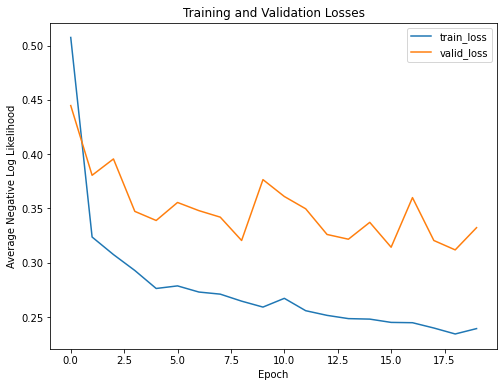

In [0]:

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

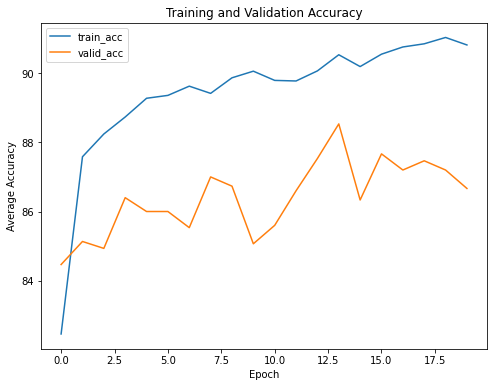

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [0]:
correct = 0
total = 0
device = torch.device("cuda")
vgg16.to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 93 %


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
vgg16.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for VGG on Train Data')

tensor([[3974.,  945.],
        [ 176., 6905.]])


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
vgg16.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for VGG on validation Data')

tensor([[485., 130.],
        [ 64., 821.]])


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
vgg16.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for VGG on Test Data')

tensor([[533.,  82.],
        [ 15., 870.]])


# Working on Resnet here

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
resnet = models.resnet18(pretrained=True).to(device)
# print(resnet)

In [0]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

resnet.fc = nn.Sequential(
               nn.Linear(512, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 2)).to(device)

In [0]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet.parameters():
    param.requires_grad = False
for param in resnet.fc.parameters():
    param.requires_grad = True


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)

In [0]:
model, history = corona(resnet, trainloader, validloader, 20, 'res18_FC_Only.pth')



0it [00:00, ?it/s]

1it [00:04,  4.57s/it]

2it [00:04,  3.24s/it]

3it [00:04,  2.31s/it]

5it [00:08,  2.21s/it]

6it [00:08,  1.59s/it]

7it [00:09,  1.16s/it]

8it [00:09,  1.19it/s]

9it [00:13,  1.86s/it]

10it [00:13,  1.34s/it]

11it [00:13,  1.02it/s]

12it [00:13,  1.39it/s]

13it [00:17,  1.63s/it]

14it [00:17,  1.18s/it]

15it [00:18,  1.07it/s]

16it [00:18,  1.45it/s]

17it [00:21,  1.55s/it]

18it [00:21,  1.12s/it]

19it [00:22,  1.14it/s]

20it [00:22,  1.53it/s]

21it [00:25,  1.53s/it]

22it [00:26,  1.21s/it]

23it [00:26,  1.11it/s]

24it [00:26,  1.50it/s]

25it [00:30,  1.52s/it]

26it [00:30,  1.21s/it]

27it [00:30,  1.12it/s]

28it [00:30,  1.51it/s]

29it [00:34,  1.48s/it]

30it [00:34,  1.22s/it]

31it [00:35,  1.12it/s]

32it [00:35,  1.51it/s]

33it [00:38,  1.47s/it]

34it [00:39,  1.19s/it]

35it [00:39,  1.10it/s]

36it [00:39,  1.50it/s]

37it [00:42,  1.49s/it]

38it [00:43,  1.18s/it]

39it [00:43,  1.01s/it]

40it [00:44,  1.34it/s]

41it [00:47

Epoch # 0 		Training loss:  0.36528109323154107 	 Validation loss:  0.3779537205894788
		Training Accuracy:  84.125 	 Validation Accuracy:  83.39999999999999





0it [00:00, ?it/s]

1it [00:04,  4.26s/it]

2it [00:04,  3.18s/it]

3it [00:05,  2.26s/it]

4it [00:05,  1.61s/it]

5it [00:08,  2.14s/it]

6it [00:09,  1.68s/it]

7it [00:09,  1.22s/it]

8it [00:09,  1.13it/s]

9it [00:12,  1.58s/it]

10it [00:13,  1.38s/it]

11it [00:13,  1.01s/it]

12it [00:13,  1.34it/s]

13it [00:16,  1.46s/it]

14it [00:17,  1.33s/it]

15it [00:18,  1.03it/s]

16it [00:18,  1.40it/s]

17it [00:20,  1.26s/it]

18it [00:22,  1.40s/it]

19it [00:22,  1.03s/it]

20it [00:22,  1.33it/s]

21it [00:24,  1.16s/it]

22it [00:26,  1.43s/it]

23it [00:26,  1.04s/it]

24it [00:27,  1.30it/s]

25it [00:28,  1.09s/it]

26it [00:31,  1.44s/it]

27it [00:31,  1.05s/it]

28it [00:31,  1.30it/s]

29it [00:33,  1.05s/it]

30it [00:35,  1.45s/it]

31it [00:35,  1.06s/it]

32it [00:35,  1.29it/s]

33it [00:37,  1.00it/s]

34it [00:39,  1.43s/it]

35it [00:40,  1.20s/it]

36it [00:40,  1.15it/s]

37it [00:41,  1.23it/s]

38it [00:43,  1.39s/it]

39it [00:44,  1.20s/it]

40it [00:44

Epoch # 1 		Training loss:  0.3210210549704572 	 Validation loss:  0.36150120322902995
		Training Accuracy:  86.61666666666666 	 Validation Accuracy:  84.06666666666666





0it [00:00, ?it/s]

1it [00:04,  4.18s/it]

2it [00:04,  2.97s/it]

3it [00:04,  2.12s/it]

4it [00:04,  1.51s/it]

5it [00:08,  2.25s/it]

6it [00:08,  1.60s/it]

7it [00:08,  1.17s/it]

8it [00:08,  1.17it/s]

9it [00:12,  1.76s/it]

10it [00:12,  1.26s/it]

11it [00:13,  1.07it/s]

12it [00:13,  1.46it/s]

13it [00:16,  1.63s/it]

15it [00:17,  1.24s/it]

16it [00:17,  1.11it/s]

17it [00:21,  1.73s/it]

18it [00:21,  1.25s/it]

19it [00:21,  1.09it/s]

20it [00:21,  1.48it/s]

21it [00:25,  1.62s/it]

22it [00:25,  1.17s/it]

23it [00:25,  1.17it/s]

24it [00:25,  1.58it/s]

25it [00:29,  1.59s/it]

26it [00:29,  1.15s/it]

27it [00:30,  1.17it/s]

28it [00:30,  1.36it/s]

29it [00:34,  1.57s/it]

30it [00:34,  1.13s/it]

31it [00:34,  1.19it/s]

32it [00:34,  1.32it/s]

33it [00:38,  1.50s/it]

34it [00:38,  1.08s/it]

35it [00:38,  1.12it/s]

36it [00:39,  1.18it/s]

37it [00:43,  1.71s/it]

38it [00:43,  1.24s/it]

39it [00:43,  1.10it/s]

40it [00:43,  1.34it/s]

41it [00:47

Epoch # 2 		Training loss:  0.3168369007712983 	 Validation loss:  0.36549622875948745
		Training Accuracy:  86.48333333333333 	 Validation Accuracy:  83.86666666666667





0it [00:00, ?it/s]

1it [00:04,  4.36s/it]

2it [00:04,  3.09s/it]

3it [00:04,  2.20s/it]

4it [00:04,  1.58s/it]

5it [00:08,  2.26s/it]

6it [00:08,  1.62s/it]

7it [00:08,  1.19s/it]

8it [00:09,  1.13it/s]

9it [00:12,  1.70s/it]

10it [00:12,  1.22s/it]

11it [00:13,  1.05it/s]

12it [00:13,  1.38it/s]

13it [00:16,  1.60s/it]

14it [00:17,  1.16s/it]

15it [00:17,  1.17it/s]

16it [00:17,  1.41it/s]

17it [00:21,  1.69s/it]

18it [00:21,  1.22s/it]

19it [00:21,  1.11it/s]

20it [00:21,  1.51it/s]

21it [00:25,  1.65s/it]

22it [00:26,  1.19s/it]

23it [00:26,  1.14it/s]

24it [00:26,  1.54it/s]

25it [00:29,  1.57s/it]

26it [00:30,  1.14s/it]

27it [00:30,  1.19it/s]

28it [00:30,  1.61it/s]

29it [00:34,  1.56s/it]

30it [00:34,  1.13s/it]

31it [00:34,  1.20it/s]

32it [00:34,  1.58it/s]

33it [00:38,  1.55s/it]

34it [00:38,  1.12s/it]

35it [00:38,  1.19it/s]

36it [00:38,  1.61it/s]

37it [00:42,  1.70s/it]

38it [00:43,  1.23s/it]

39it [00:43,  1.11it/s]

40it [00:43

Epoch # 3 		Training loss:  0.30525461409954313 	 Validation loss:  0.36355527055760223
		Training Accuracy:  87.38333333333334 	 Validation Accuracy:  84.33333333333334





0it [00:00, ?it/s]

1it [00:04,  4.34s/it]

2it [00:04,  3.07s/it]

3it [00:04,  2.20s/it]

4it [00:04,  1.57s/it]

5it [00:08,  2.26s/it]

6it [00:08,  1.62s/it]

7it [00:08,  1.18s/it]

8it [00:08,  1.17it/s]

9it [00:12,  1.75s/it]

10it [00:12,  1.26s/it]

11it [00:13,  1.08it/s]

12it [00:13,  1.28it/s]

13it [00:17,  1.59s/it]

14it [00:17,  1.19s/it]

15it [00:17,  1.14it/s]

16it [00:17,  1.37it/s]

17it [00:22,  1.77s/it]

18it [00:22,  1.28s/it]

19it [00:22,  1.07it/s]

20it [00:22,  1.45it/s]

21it [00:26,  1.64s/it]

22it [00:26,  1.18s/it]

23it [00:26,  1.16it/s]

24it [00:26,  1.57it/s]

25it [00:30,  1.63s/it]

26it [00:30,  1.18s/it]

27it [00:30,  1.14it/s]

28it [00:30,  1.56it/s]

29it [00:34,  1.61s/it]

30it [00:34,  1.16s/it]

31it [00:35,  1.18it/s]

32it [00:35,  1.44it/s]

33it [00:39,  1.62s/it]

34it [00:39,  1.16s/it]

35it [00:39,  1.17it/s]

36it [00:39,  1.58it/s]

37it [00:43,  1.59s/it]

38it [00:43,  1.15s/it]

39it [00:43,  1.18it/s]

40it [00:43

Epoch # 4 		Training loss:  0.3112669899425608 	 Validation loss:  0.37293720493714017
		Training Accuracy:  87.19166666666666 	 Validation Accuracy:  83.73333333333333





0it [00:00, ?it/s]

1it [00:04,  4.20s/it]

2it [00:04,  3.01s/it]

3it [00:04,  2.16s/it]

4it [00:04,  1.55s/it]

5it [00:08,  2.27s/it]

6it [00:09,  1.75s/it]

7it [00:09,  1.28s/it]

8it [00:09,  1.08it/s]

9it [00:13,  1.90s/it]

10it [00:13,  1.36s/it]

11it [00:13,  1.00it/s]

12it [00:14,  1.36it/s]

13it [00:18,  1.75s/it]

14it [00:18,  1.26s/it]

15it [00:18,  1.09it/s]

16it [00:18,  1.46it/s]

17it [00:23,  1.96s/it]

18it [00:23,  1.41s/it]

19it [00:23,  1.02s/it]

20it [00:23,  1.33it/s]

21it [00:27,  1.69s/it]

22it [00:27,  1.22s/it]

23it [00:28,  1.11it/s]

24it [00:28,  1.51it/s]

25it [00:31,  1.61s/it]

26it [00:32,  1.16s/it]

27it [00:32,  1.17it/s]

28it [00:32,  1.58it/s]

29it [00:36,  1.64s/it]

30it [00:36,  1.18s/it]

31it [00:36,  1.15it/s]

32it [00:36,  1.55it/s]

33it [00:40,  1.50s/it]

34it [00:40,  1.08s/it]

35it [00:40,  1.25it/s]

36it [00:40,  1.67it/s]

37it [00:45,  1.77s/it]

38it [00:45,  1.28s/it]

39it [00:45,  1.07it/s]

40it [00:45

Epoch # 5 		Training loss:  0.3027756518505989 	 Validation loss:  0.37051062658429146
		Training Accuracy:  87.50833333333333 	 Validation Accuracy:  84.2





0it [00:00, ?it/s]

1it [00:04,  4.35s/it]

2it [00:04,  3.08s/it]

3it [00:04,  2.19s/it]

4it [00:04,  1.57s/it]

5it [00:07,  2.08s/it]

6it [00:08,  1.74s/it]

7it [00:09,  1.26s/it]

8it [00:09,  1.09it/s]

9it [00:12,  1.75s/it]

10it [00:13,  1.44s/it]

11it [00:13,  1.05s/it]

12it [00:13,  1.29it/s]

13it [00:17,  1.54s/it]

14it [00:17,  1.25s/it]

15it [00:17,  1.09it/s]

16it [00:18,  1.47it/s]

17it [00:21,  1.47s/it]

18it [00:22,  1.32s/it]

19it [00:22,  1.04it/s]

20it [00:22,  1.41it/s]

21it [00:25,  1.30s/it]

22it [00:26,  1.34s/it]

23it [00:26,  1.02it/s]

24it [00:26,  1.39it/s]

25it [00:29,  1.35s/it]

26it [00:30,  1.29s/it]

27it [00:31,  1.05it/s]

28it [00:31,  1.44it/s]

29it [00:34,  1.37s/it]

30it [00:35,  1.28s/it]

31it [00:35,  1.06it/s]

32it [00:35,  1.44it/s]

33it [00:37,  1.20s/it]

34it [00:39,  1.28s/it]

35it [00:39,  1.06it/s]

36it [00:39,  1.33it/s]

37it [00:42,  1.24s/it]

38it [00:43,  1.23s/it]

39it [00:43,  1.03it/s]

40it [00:44

Epoch # 6 		Training loss:  0.2892265711772315 	 Validation loss:  0.3533601102729638
		Training Accuracy:  88.48333333333333 	 Validation Accuracy:  83.33333333333334





0it [00:00, ?it/s]

1it [00:04,  4.24s/it]

2it [00:04,  3.00s/it]

3it [00:04,  2.15s/it]

4it [00:04,  1.53s/it]

5it [00:08,  2.22s/it]

6it [00:08,  1.59s/it]

7it [00:08,  1.16s/it]

8it [00:08,  1.18it/s]

9it [00:12,  1.77s/it]

10it [00:12,  1.28s/it]

11it [00:12,  1.07it/s]

13it [00:17,  1.26s/it]

14it [00:17,  1.09it/s]

15it [00:17,  1.46it/s]

16it [00:17,  1.94it/s]

17it [00:21,  1.52s/it]

18it [00:21,  1.10s/it]

19it [00:21,  1.24it/s]

20it [00:21,  1.66it/s]

21it [00:25,  1.56s/it]

22it [00:25,  1.13s/it]

23it [00:25,  1.21it/s]

24it [00:25,  1.63it/s]

25it [00:29,  1.58s/it]

26it [00:29,  1.16s/it]

27it [00:30,  1.17it/s]

28it [00:30,  1.57it/s]

29it [00:33,  1.54s/it]

30it [00:34,  1.24s/it]

31it [00:34,  1.09it/s]

32it [00:34,  1.48it/s]

33it [00:38,  1.66s/it]

34it [00:38,  1.19s/it]

35it [00:38,  1.14it/s]

36it [00:38,  1.54it/s]

37it [00:43,  1.70s/it]

38it [00:43,  1.22s/it]

39it [00:43,  1.11it/s]

40it [00:43,  1.51it/s]

41it [00:47

Epoch # 7 		Training loss:  0.2842678688466549 	 Validation loss:  0.37490538445611793
		Training Accuracy:  88.25 	 Validation Accuracy:  83.2





0it [00:00, ?it/s]

1it [00:04,  4.21s/it]

2it [00:05,  3.34s/it]

3it [00:05,  2.39s/it]

4it [00:05,  1.71s/it]

5it [00:08,  2.02s/it]

6it [00:09,  1.71s/it]

7it [00:09,  1.24s/it]

8it [00:09,  1.12it/s]

9it [00:13,  1.67s/it]

10it [00:14,  1.43s/it]

11it [00:14,  1.04s/it]

12it [00:14,  1.31it/s]

13it [00:17,  1.49s/it]

14it [00:18,  1.32s/it]

15it [00:18,  1.03it/s]

16it [00:18,  1.41it/s]

17it [00:21,  1.29s/it]

18it [00:22,  1.35s/it]

19it [00:23,  1.01it/s]

20it [00:23,  1.38it/s]

21it [00:25,  1.34s/it]

22it [00:27,  1.37s/it]

23it [00:27,  1.00s/it]

24it [00:27,  1.36it/s]

25it [00:30,  1.32s/it]

26it [00:31,  1.40s/it]

27it [00:32,  1.02s/it]

28it [00:32,  1.32it/s]

29it [00:34,  1.30s/it]

30it [00:36,  1.37s/it]

31it [00:36,  1.01s/it]

32it [00:36,  1.35it/s]

33it [00:38,  1.25s/it]

34it [00:40,  1.33s/it]

35it [00:40,  1.02it/s]

36it [00:40,  1.35it/s]

37it [00:43,  1.23s/it]

38it [00:44,  1.31s/it]

39it [00:44,  1.03it/s]

40it [00:45

Epoch # 8 		Training loss:  0.2933159401600665 	 Validation loss:  0.3579168214152257
		Training Accuracy:  88.21666666666667 	 Validation Accuracy:  84.66666666666667





0it [00:00, ?it/s]

1it [00:04,  4.30s/it]

2it [00:04,  3.04s/it]

3it [00:04,  2.18s/it]

4it [00:04,  1.56s/it]

5it [00:08,  2.25s/it]

6it [00:08,  1.61s/it]

7it [00:09,  1.38s/it]

8it [00:09,  1.01s/it]

9it [00:12,  1.70s/it]

10it [00:13,  1.23s/it]

11it [00:14,  1.27s/it]

12it [00:14,  1.08it/s]

13it [00:17,  1.44s/it]

14it [00:17,  1.04s/it]

15it [00:19,  1.27s/it]

16it [00:19,  1.08it/s]

17it [00:21,  1.37s/it]

18it [00:21,  1.01it/s]

19it [00:23,  1.24s/it]

20it [00:23,  1.11it/s]

21it [00:25,  1.31s/it]

22it [00:26,  1.05it/s]

23it [00:28,  1.40s/it]

24it [00:28,  1.02s/it]

25it [00:30,  1.24s/it]

26it [00:30,  1.11it/s]

27it [00:33,  1.59s/it]

28it [00:33,  1.15s/it]

29it [00:34,  1.11s/it]

30it [00:34,  1.23it/s]

31it [00:38,  1.53s/it]

32it [00:38,  1.10s/it]

33it [00:39,  1.02s/it]

34it [00:39,  1.10it/s]

35it [00:43,  1.64s/it]

36it [00:43,  1.18s/it]

37it [00:43,  1.05it/s]

38it [00:44,  1.25it/s]

39it [00:47,  1.58s/it]

40it [00:47

Epoch # 9 		Training loss:  0.28319138106196484 	 Validation loss:  0.45519457136591274
		Training Accuracy:  88.28333333333333 	 Validation Accuracy:  80.26666666666667





0it [00:00, ?it/s]

1it [00:04,  4.28s/it]

2it [00:04,  3.03s/it]

3it [00:04,  2.17s/it]

4it [00:04,  1.56s/it]

5it [00:08,  2.29s/it]

6it [00:08,  1.64s/it]

7it [00:08,  1.20s/it]

8it [00:09,  1.15it/s]

9it [00:12,  1.75s/it]

10it [00:13,  1.27s/it]

11it [00:13,  1.07it/s]

12it [00:13,  1.45it/s]

13it [00:17,  1.68s/it]

14it [00:17,  1.22s/it]

15it [00:17,  1.11it/s]

16it [00:17,  1.51it/s]

17it [00:21,  1.58s/it]

18it [00:21,  1.17s/it]

19it [00:21,  1.16it/s]

21it [00:25,  1.17s/it]

22it [00:26,  1.07s/it]

23it [00:26,  1.25it/s]

24it [00:26,  1.67it/s]

25it [00:29,  1.39s/it]

26it [00:30,  1.17s/it]

27it [00:30,  1.16it/s]

28it [00:30,  1.56it/s]

29it [00:34,  1.44s/it]

30it [00:34,  1.22s/it]

31it [00:35,  1.12it/s]

32it [00:35,  1.50it/s]

33it [00:38,  1.47s/it]

34it [00:39,  1.27s/it]

35it [00:39,  1.07it/s]

36it [00:39,  1.45it/s]

37it [00:43,  1.61s/it]

38it [00:43,  1.18s/it]

39it [00:43,  1.15it/s]

40it [00:43,  1.55it/s]

41it [00:47

Epoch # 10 		Training loss:  0.283071368457155 	 Validation loss:  0.3549888400981824
		Training Accuracy:  88.39166666666667 	 Validation Accuracy:  83.8





0it [00:00, ?it/s]

1it [00:04,  4.30s/it]

2it [00:04,  3.05s/it]

3it [00:04,  2.19s/it]

4it [00:04,  1.57s/it]

5it [00:08,  2.22s/it]

6it [00:08,  1.64s/it]

7it [00:08,  1.19s/it]

8it [00:08,  1.16it/s]

9it [00:12,  1.74s/it]

10it [00:13,  1.31s/it]

11it [00:13,  1.04it/s]

12it [00:13,  1.41it/s]

13it [00:17,  1.64s/it]

14it [00:17,  1.19s/it]

15it [00:17,  1.13it/s]

16it [00:17,  1.50it/s]

17it [00:21,  1.55s/it]

18it [00:21,  1.23s/it]

19it [00:21,  1.11it/s]

20it [00:22,  1.32it/s]

21it [00:25,  1.51s/it]

22it [00:25,  1.17s/it]

23it [00:26,  1.16it/s]

24it [00:26,  1.35it/s]

25it [00:29,  1.47s/it]

26it [00:30,  1.18s/it]

27it [00:30,  1.15it/s]

28it [00:31,  1.24it/s]

29it [00:33,  1.45s/it]

30it [00:34,  1.17s/it]

31it [00:34,  1.14it/s]

32it [00:35,  1.36it/s]

33it [00:38,  1.50s/it]

34it [00:38,  1.15s/it]

35it [00:39,  1.09it/s]

36it [00:39,  1.16it/s]

37it [00:42,  1.51s/it]

38it [00:43,  1.16s/it]

39it [00:43,  1.11it/s]

40it [00:43

Epoch # 11 		Training loss:  0.2871134178911118 	 Validation loss:  0.3641140256077051
		Training Accuracy:  88.08333333333334 	 Validation Accuracy:  82.39999999999999





0it [00:00, ?it/s]

1it [00:04,  4.11s/it]

2it [00:04,  2.96s/it]

3it [00:04,  2.11s/it]

4it [00:04,  1.51s/it]

5it [00:08,  2.17s/it]

6it [00:08,  1.61s/it]

7it [00:08,  1.19s/it]

8it [00:08,  1.15it/s]

9it [00:12,  1.74s/it]

10it [00:13,  1.41s/it]

11it [00:13,  1.03s/it]

12it [00:13,  1.33it/s]

13it [00:17,  1.55s/it]

14it [00:17,  1.27s/it]

15it [00:17,  1.07it/s]

16it [00:17,  1.45it/s]

17it [00:21,  1.52s/it]

18it [00:21,  1.21s/it]

19it [00:22,  1.03it/s]

20it [00:22,  1.40it/s]

21it [00:25,  1.47s/it]

22it [00:26,  1.20s/it]

23it [00:26,  1.06it/s]

24it [00:26,  1.44it/s]

25it [00:30,  1.49s/it]

26it [00:30,  1.21s/it]

27it [00:30,  1.07it/s]

28it [00:30,  1.46it/s]

29it [00:34,  1.48s/it]

30it [00:34,  1.24s/it]

31it [00:35,  1.09it/s]

33it [00:38,  1.15s/it]

34it [00:39,  1.00s/it]

35it [00:39,  1.32it/s]

36it [00:39,  1.78it/s]

37it [00:42,  1.41s/it]

38it [00:43,  1.17s/it]

39it [00:43,  1.15it/s]

40it [00:43,  1.55it/s]

41it [00:47

Epoch # 12 		Training loss:  0.28257693881367113 	 Validation loss:  0.34918097717066604
		Training Accuracy:  88.325 	 Validation Accuracy:  83.93333333333334





0it [00:00, ?it/s]

1it [00:04,  4.17s/it]

2it [00:04,  3.03s/it]

3it [00:05,  2.30s/it]

4it [00:05,  1.65s/it]

5it [00:08,  2.07s/it]

6it [00:09,  1.76s/it]

7it [00:09,  1.42s/it]

8it [00:10,  1.03s/it]

9it [00:12,  1.54s/it]

10it [00:13,  1.36s/it]

11it [00:14,  1.11s/it]

12it [00:14,  1.22it/s]

13it [00:16,  1.33s/it]

14it [00:18,  1.30s/it]

15it [00:18,  1.08s/it]

16it [00:18,  1.26it/s]

17it [00:21,  1.26s/it]

18it [00:22,  1.26s/it]

19it [00:23,  1.15s/it]

20it [00:23,  1.19it/s]

21it [00:25,  1.11s/it]

22it [00:26,  1.27s/it]

23it [00:27,  1.09s/it]

24it [00:27,  1.26it/s]

25it [00:29,  1.05s/it]

26it [00:31,  1.33s/it]

27it [00:31,  1.11s/it]

28it [00:32,  1.23it/s]

29it [00:33,  1.08s/it]

30it [00:36,  1.53s/it]

31it [00:36,  1.11s/it]

32it [00:36,  1.23it/s]

33it [00:37,  1.03it/s]

34it [00:40,  1.52s/it]

35it [00:40,  1.11s/it]

36it [00:40,  1.23it/s]

37it [00:42,  1.09it/s]

38it [00:44,  1.50s/it]

39it [00:45,  1.13s/it]

40it [00:45

Epoch # 13 		Training loss:  0.2805552564640629 	 Validation loss:  0.350743077074488
		Training Accuracy:  88.68333333333334 	 Validation Accuracy:  84.26666666666667





0it [00:00, ?it/s]

1it [00:04,  4.99s/it]

2it [00:05,  3.52s/it]

3it [00:05,  2.51s/it]

4it [00:05,  1.79s/it]

5it [00:08,  2.33s/it]

6it [00:09,  1.66s/it]

7it [00:09,  1.21s/it]

8it [00:09,  1.14it/s]

9it [00:13,  2.00s/it]

10it [00:14,  1.43s/it]

11it [00:14,  1.05s/it]

12it [00:14,  1.31it/s]

13it [00:18,  1.73s/it]

14it [00:18,  1.25s/it]

15it [00:18,  1.09it/s]

16it [00:18,  1.47it/s]

17it [00:22,  1.68s/it]

18it [00:22,  1.21s/it]

19it [00:22,  1.12it/s]

20it [00:23,  1.51it/s]

21it [00:27,  1.66s/it]

22it [00:27,  1.20s/it]

23it [00:27,  1.13it/s]

24it [00:27,  1.53it/s]

25it [00:31,  1.66s/it]

26it [00:31,  1.20s/it]

27it [00:31,  1.12it/s]

28it [00:31,  1.52it/s]

29it [00:35,  1.65s/it]

30it [00:35,  1.19s/it]

31it [00:36,  1.14it/s]

32it [00:36,  1.55it/s]

33it [00:39,  1.58s/it]

34it [00:40,  1.15s/it]

35it [00:40,  1.18it/s]

36it [00:40,  1.59it/s]

37it [00:44,  1.59s/it]

38it [00:44,  1.15s/it]

39it [00:44,  1.18it/s]

40it [00:44

Epoch # 14 		Training loss:  0.28178005756691415 	 Validation loss:  0.3487272635102272
		Training Accuracy:  88.60833333333333 	 Validation Accuracy:  83.8





0it [00:00, ?it/s]

1it [00:04,  4.09s/it]

2it [00:04,  2.98s/it]

3it [00:04,  2.13s/it]

4it [00:04,  1.53s/it]

5it [00:08,  2.24s/it]

6it [00:08,  1.61s/it]

7it [00:08,  1.17s/it]

8it [00:09,  1.17it/s]

9it [00:12,  1.78s/it]

10it [00:13,  1.28s/it]

11it [00:13,  1.13s/it]

12it [00:13,  1.22it/s]

13it [00:17,  1.58s/it]

14it [00:17,  1.14s/it]

15it [00:18,  1.03s/it]

16it [00:18,  1.32it/s]

17it [00:21,  1.57s/it]

18it [00:21,  1.14s/it]

19it [00:22,  1.05it/s]

20it [00:22,  1.42it/s]

21it [00:26,  1.56s/it]

22it [00:26,  1.12s/it]

23it [00:26,  1.07it/s]

24it [00:26,  1.45it/s]

25it [00:30,  1.65s/it]

26it [00:30,  1.19s/it]

27it [00:31,  1.14it/s]

28it [00:31,  1.54it/s]

29it [00:35,  1.62s/it]

30it [00:35,  1.25s/it]

31it [00:35,  1.08it/s]

32it [00:35,  1.46it/s]

33it [00:39,  1.56s/it]

34it [00:39,  1.20s/it]

35it [00:39,  1.11it/s]

37it [00:43,  1.23s/it]

38it [00:44,  1.10it/s]

39it [00:44,  1.47it/s]

40it [00:44,  1.95it/s]

41it [00:48

Epoch # 15 		Training loss:  0.28598593555866403 	 Validation loss:  0.34720227867364883
		Training Accuracy:  88.13333333333333 	 Validation Accuracy:  83.73333333333333





0it [00:00, ?it/s]

1it [00:04,  4.40s/it]

2it [00:04,  3.11s/it]

3it [00:04,  2.22s/it]

4it [00:04,  1.59s/it]

5it [00:08,  2.26s/it]

6it [00:08,  1.65s/it]

7it [00:08,  1.20s/it]

8it [00:09,  1.15it/s]

9it [00:12,  1.75s/it]

10it [00:13,  1.32s/it]

11it [00:13,  1.03it/s]

12it [00:13,  1.39it/s]

13it [00:17,  1.61s/it]

14it [00:18,  1.48s/it]

15it [00:18,  1.07s/it]

16it [00:18,  1.27it/s]

17it [00:21,  1.43s/it]

18it [00:23,  1.45s/it]

19it [00:23,  1.05s/it]

20it [00:23,  1.30it/s]

21it [00:26,  1.37s/it]

22it [00:27,  1.36s/it]

23it [00:27,  1.00it/s]

24it [00:27,  1.36it/s]

25it [00:30,  1.33s/it]

26it [00:31,  1.38s/it]

27it [00:32,  1.01s/it]

28it [00:32,  1.36it/s]

29it [00:34,  1.31s/it]

30it [00:36,  1.33s/it]

31it [00:36,  1.03it/s]

32it [00:36,  1.39it/s]

33it [00:39,  1.40s/it]

34it [00:40,  1.20s/it]

35it [00:40,  1.13it/s]

36it [00:40,  1.53it/s]

37it [00:43,  1.47s/it]

38it [00:44,  1.22s/it]

39it [00:44,  1.12it/s]

40it [00:44

Epoch # 16 		Training loss:  0.2732231116833839 	 Validation loss:  0.34911294654011726
		Training Accuracy:  88.75 	 Validation Accuracy:  84.93333333333334





0it [00:00, ?it/s]

1it [00:04,  4.97s/it]

2it [00:05,  3.52s/it]

3it [00:05,  2.50s/it]

4it [00:05,  1.79s/it]

5it [00:09,  2.42s/it]

6it [00:09,  1.73s/it]

7it [00:09,  1.25s/it]

8it [00:09,  1.10it/s]

9it [00:13,  1.91s/it]

10it [00:13,  1.37s/it]

11it [00:14,  1.00s/it]

12it [00:14,  1.36it/s]

13it [00:18,  1.70s/it]

14it [00:18,  1.22s/it]

15it [00:18,  1.11it/s]

16it [00:18,  1.51it/s]

17it [00:22,  1.63s/it]

18it [00:22,  1.18s/it]

19it [00:22,  1.15it/s]

20it [00:22,  1.55it/s]

21it [00:26,  1.59s/it]

22it [00:27,  1.29s/it]

23it [00:27,  1.06it/s]

24it [00:27,  1.43it/s]

25it [00:30,  1.49s/it]

26it [00:31,  1.26s/it]

27it [00:31,  1.07it/s]

28it [00:31,  1.45it/s]

29it [00:35,  1.50s/it]

30it [00:36,  1.32s/it]

31it [00:36,  1.03it/s]

32it [00:36,  1.39it/s]

33it [00:39,  1.42s/it]

34it [00:40,  1.30s/it]

35it [00:40,  1.04it/s]

36it [00:40,  1.42it/s]

37it [00:43,  1.41s/it]

38it [00:44,  1.32s/it]

39it [00:45,  1.03it/s]

40it [00:45

Epoch # 17 		Training loss:  0.27998244913017495 	 Validation loss:  0.3481106503556172
		Training Accuracy:  88.60833333333333 	 Validation Accuracy:  84.46666666666667





0it [00:00, ?it/s]

1it [00:04,  4.29s/it]

2it [00:05,  3.26s/it]

3it [00:05,  2.33s/it]

4it [00:05,  1.66s/it]

5it [00:08,  2.10s/it]

6it [00:09,  1.76s/it]

7it [00:09,  1.27s/it]

8it [00:09,  1.08it/s]

9it [00:12,  1.52s/it]

10it [00:13,  1.45s/it]

11it [00:14,  1.05s/it]

12it [00:14,  1.30it/s]

13it [00:17,  1.42s/it]

14it [00:18,  1.39s/it]

15it [00:18,  1.02s/it]

16it [00:18,  1.34it/s]

17it [00:21,  1.39s/it]

18it [00:22,  1.35s/it]

19it [00:23,  1.01it/s]

20it [00:23,  1.37it/s]

21it [00:25,  1.35s/it]

22it [00:27,  1.36s/it]

23it [00:27,  1.00it/s]

24it [00:27,  1.36it/s]

25it [00:30,  1.33s/it]

26it [00:31,  1.32s/it]

27it [00:31,  1.03it/s]

28it [00:31,  1.39it/s]

29it [00:34,  1.32s/it]

30it [00:36,  1.35s/it]

31it [00:36,  1.01it/s]

32it [00:36,  1.38it/s]

33it [00:38,  1.32s/it]

34it [00:40,  1.38s/it]

35it [00:40,  1.01s/it]

36it [00:40,  1.34it/s]

37it [00:43,  1.27s/it]

38it [00:44,  1.38s/it]

39it [00:45,  1.01s/it]

40it [00:45

Epoch # 18 		Training loss:  0.26905436992169696 	 Validation loss:  0.3523851564774911
		Training Accuracy:  88.98333333333333 	 Validation Accuracy:  84.2





0it [00:00, ?it/s]

1it [00:04,  4.29s/it]

2it [00:04,  3.04s/it]

3it [00:05,  2.34s/it]

4it [00:05,  1.67s/it]

5it [00:08,  2.16s/it]

6it [00:08,  1.58s/it]

7it [00:09,  1.27s/it]

8it [00:09,  1.08it/s]

9it [00:12,  1.70s/it]

10it [00:13,  1.22s/it]

11it [00:13,  1.03it/s]

12it [00:13,  1.40it/s]

13it [00:17,  1.68s/it]

14it [00:17,  1.21s/it]

15it [00:18,  1.03s/it]

16it [00:18,  1.33it/s]

17it [00:21,  1.61s/it]

18it [00:22,  1.17s/it]

19it [00:22,  1.02it/s]

20it [00:22,  1.39it/s]

21it [00:26,  1.56s/it]

22it [00:26,  1.14s/it]

23it [00:26,  1.03it/s]

24it [00:27,  1.39it/s]

25it [00:31,  1.68s/it]

26it [00:31,  1.21s/it]

27it [00:31,  1.10it/s]

28it [00:31,  1.49it/s]

29it [00:35,  1.66s/it]

30it [00:35,  1.20s/it]

31it [00:35,  1.12it/s]

32it [00:35,  1.50it/s]

33it [00:39,  1.68s/it]

34it [00:40,  1.21s/it]

35it [00:40,  1.12it/s]

36it [00:40,  1.53it/s]

37it [00:44,  1.63s/it]

38it [00:44,  1.18s/it]

39it [00:44,  1.14it/s]

40it [00:44

Epoch # 19 		Training loss:  0.27779580268295523 	 Validation loss:  0.3517129570245743
		Training Accuracy:  88.53333333333333 	 Validation Accuracy:  84.2


Text(0.5, 1.0, 'Training and Validation Losses')

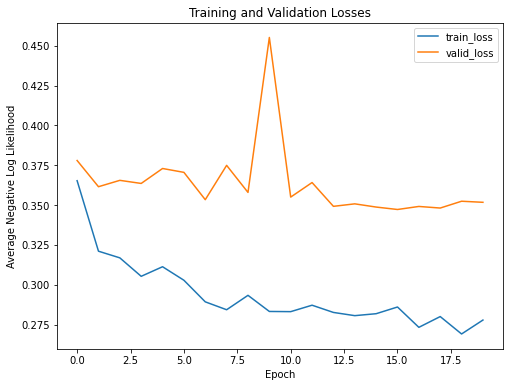

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

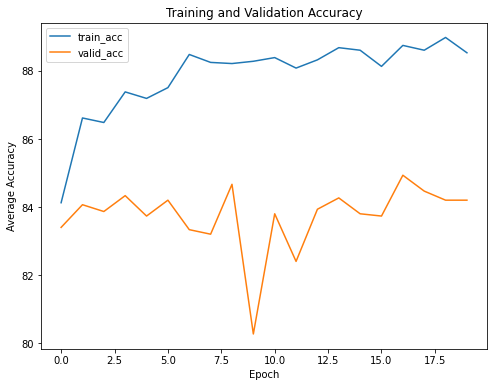

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [0]:
correct = 0
total = 0
device = torch.device("cuda")
resnet.to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 validation images: 91 %


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
resnet.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for Resnet on Train Data')

tensor([[4127.,  792.],
        [ 501., 6580.]])


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
resnet.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for Resnet on validation Data')

tensor([[472., 143.],
        [104., 781.]])


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
resnet.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for Resnet on Test Data')

tensor([[525.,  90.],
        [ 43., 842.]])


# Task2 starts here

# VGG working here

In [14]:
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
vgg16.classifier[0].out_features = 770
vgg16.classifier[3].in_features = 770
vgg16.classifier[3].out_features = 2
# vgg16.classifier[4] = nn.Softmax(dim=1)

In [16]:
print(vgg16.classifier[6])

Linear(in_features=4096, out_features=1000, bias=True)


In [17]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-3] # Remove last layer
print(features)


[Linear(in_features=25088, out_features=770, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=770, out_features=2, bias=True)]


In [19]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
for param in vgg16.features[17:].parameters():
    param.requires_grad = False

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

In [22]:
model, history = corona(vgg16, trainloader, validloader, Epochs = 10, name = 'vgg16_entire.pth')


0it [00:00, ?it/s]
1it [00:03,  3.01s/it]
2it [00:03,  2.28s/it]
3it [00:04,  1.78s/it]
4it [00:04,  1.41s/it]
5it [00:05,  1.29s/it]
6it [00:06,  1.08s/it]
7it [00:06,  1.08it/s]
8it [00:07,  1.22it/s]
9it [00:08,  1.14it/s]
10it [00:09,  1.28it/s]
11it [00:09,  1.38it/s]
12it [00:10,  1.48it/s]
13it [00:11,  1.28it/s]
14it [00:11,  1.39it/s]
15it [00:12,  1.47it/s]
16it [00:12,  1.55it/s]
17it [00:13,  1.33it/s]
18it [00:14,  1.45it/s]
19it [00:15,  1.54it/s]
20it [00:15,  1.62it/s]
21it [00:16,  1.37it/s]
22it [00:17,  1.48it/s]
23it [00:17,  1.55it/s]
24it [00:18,  1.63it/s]
25it [00:19,  1.35it/s]
26it [00:19,  1.46it/s]
27it [00:20,  1.54it/s]
28it [00:20,  1.62it/s]
29it [00:21,  1.36it/s]
30it [00:22,  1.48it/s]
31it [00:23,  1.56it/s]
32it [00:23,  1.63it/s]
33it [00:24,  1.40it/s]
34it [00:25,  1.50it/s]
35it [00:25,  1.57it/s]
36it [00:26,  1.64it/s]
37it [00:27,  1.43it/s]
38it [00:27,  1.53it/s]
39it [00:28,  1.59it/s]
40it [00:28,  1.64it/s]
41it [00:29,  1.41it/s]
42it 

Epoch # 0 		Training loss:  116998308893679.48 	 Validation loss:  0.7515152185521228
		Training Accuracy:  53.29166666666667 	 Validation Accuracy:  58.46666666666667




0it [00:00, ?it/s]
1it [00:02,  2.80s/it]
2it [00:03,  2.14s/it]
3it [00:04,  1.68s/it]
4it [00:04,  1.36s/it]
5it [00:05,  1.17s/it]
6it [00:05,  1.00s/it]
7it [00:06,  1.12it/s]
8it [00:07,  1.23it/s]
9it [00:08,  1.24it/s]
10it [00:08,  1.18it/s]
11it [00:09,  1.29it/s]
12it [00:10,  1.39it/s]
13it [00:10,  1.45it/s]
14it [00:11,  1.41it/s]
15it [00:12,  1.47it/s]
16it [00:12,  1.51it/s]
17it [00:13,  1.54it/s]
18it [00:14,  1.40it/s]
19it [00:14,  1.45it/s]
20it [00:15,  1.50it/s]
21it [00:16,  1.53it/s]
22it [00:16,  1.40it/s]
23it [00:17,  1.46it/s]
24it [00:18,  1.49it/s]
25it [00:18,  1.52it/s]
26it [00:19,  1.41it/s]
27it [00:20,  1.47it/s]
28it [00:20,  1.51it/s]
29it [00:21,  1.52it/s]
30it [00:22,  1.43it/s]
31it [00:22,  1.48it/s]
32it [00:23,  1.52it/s]
33it [00:24,  1.54it/s]
34it [00:24,  1.54it/s]
35it [00:25,  1.56it/s]
36it [00:26,  1.59it/s]
37it [00:26,  1.60it/s]
38it [00:27,  1.45it/s]
39it [00:28,  1.49it/s]
40it [00:28,  1.54it/s]
41it [00:29,  1.56it/s]
42it

Epoch # 1 		Training loss:  0.7734466426372528 	 Validation loss:  0.7507059307808571
		Training Accuracy:  53.30833333333334 	 Validation Accuracy:  58.666666666666664




0it [00:00, ?it/s]
1it [00:02,  2.75s/it]
2it [00:03,  2.10s/it]
3it [00:03,  1.66s/it]
4it [00:04,  1.34s/it]
5it [00:05,  1.21s/it]
6it [00:06,  1.04s/it]
7it [00:06,  1.09it/s]
8it [00:07,  1.23it/s]
9it [00:08,  1.23it/s]
10it [00:08,  1.30it/s]
11it [00:09,  1.38it/s]
12it [00:10,  1.46it/s]
13it [00:10,  1.37it/s]
14it [00:11,  1.45it/s]
15it [00:12,  1.50it/s]
16it [00:12,  1.54it/s]
17it [00:13,  1.44it/s]
18it [00:14,  1.47it/s]
19it [00:14,  1.52it/s]
20it [00:15,  1.55it/s]
21it [00:16,  1.32it/s]
22it [00:16,  1.40it/s]
23it [00:17,  1.46it/s]
24it [00:18,  1.52it/s]
25it [00:18,  1.43it/s]
26it [00:19,  1.48it/s]
27it [00:20,  1.53it/s]
28it [00:20,  1.57it/s]
29it [00:21,  1.36it/s]
30it [00:22,  1.42it/s]
31it [00:22,  1.48it/s]
32it [00:23,  1.54it/s]
33it [00:24,  1.43it/s]
34it [00:25,  1.50it/s]
35it [00:25,  1.51it/s]
36it [00:26,  1.55it/s]
37it [00:27,  1.41it/s]
38it [00:27,  1.48it/s]
39it [00:28,  1.52it/s]
40it [00:28,  1.55it/s]
41it [00:29,  1.44it/s]
42it

Epoch # 2 		Training loss:  0.7684775303204854 	 Validation loss:  0.8039254749074896
		Training Accuracy:  53.766666666666666 	 Validation Accuracy:  59.0




0it [00:00, ?it/s]
1it [00:02,  2.82s/it]
2it [00:03,  2.17s/it]
3it [00:04,  1.70s/it]
4it [00:04,  1.38s/it]
5it [00:05,  1.19s/it]
6it [00:06,  1.02s/it]
7it [00:06,  1.11it/s]
8it [00:07,  1.22it/s]
9it [00:08,  1.21it/s]
10it [00:08,  1.31it/s]
11it [00:09,  1.38it/s]
12it [00:10,  1.45it/s]
13it [00:10,  1.37it/s]
14it [00:11,  1.43it/s]
15it [00:12,  1.47it/s]
16it [00:12,  1.52it/s]
17it [00:13,  1.45it/s]
18it [00:14,  1.49it/s]
19it [00:14,  1.51it/s]
20it [00:15,  1.54it/s]
21it [00:16,  1.35it/s]
22it [00:17,  1.34it/s]
23it [00:17,  1.40it/s]
24it [00:18,  1.46it/s]
25it [00:19,  1.48it/s]
26it [00:19,  1.53it/s]
27it [00:20,  1.54it/s]
28it [00:20,  1.56it/s]
29it [00:21,  1.47it/s]
30it [00:22,  1.51it/s]
31it [00:22,  1.53it/s]
32it [00:23,  1.55it/s]
33it [00:24,  1.37it/s]
34it [00:25,  1.43it/s]
35it [00:25,  1.47it/s]
36it [00:26,  1.52it/s]
37it [00:27,  1.35it/s]
38it [00:27,  1.41it/s]
39it [00:28,  1.46it/s]
40it [00:29,  1.49it/s]
41it [00:29,  1.44it/s]
42it

Epoch # 3 		Training loss:  0.7756510043144226 	 Validation loss:  0.8020507109926102
		Training Accuracy:  53.825 	 Validation Accuracy:  58.4




0it [00:00, ?it/s]
1it [00:03,  3.11s/it]
2it [00:03,  2.36s/it]
3it [00:04,  1.84s/it]
4it [00:04,  1.48s/it]
5it [00:05,  1.28s/it]
6it [00:06,  1.08s/it]
7it [00:07,  1.05it/s]
8it [00:07,  1.19it/s]
9it [00:08,  1.26it/s]
10it [00:08,  1.35it/s]
11it [00:09,  1.41it/s]
12it [00:10,  1.47it/s]
13it [00:11,  1.37it/s]
14it [00:11,  1.43it/s]
15it [00:12,  1.47it/s]
16it [00:12,  1.52it/s]
17it [00:13,  1.44it/s]
18it [00:14,  1.49it/s]
19it [00:14,  1.51it/s]
20it [00:15,  1.54it/s]
21it [00:16,  1.48it/s]
22it [00:16,  1.52it/s]
23it [00:17,  1.54it/s]
24it [00:18,  1.56it/s]
25it [00:19,  1.28it/s]
26it [00:19,  1.36it/s]
27it [00:20,  1.42it/s]
28it [00:21,  1.46it/s]
29it [00:21,  1.42it/s]
30it [00:22,  1.48it/s]
31it [00:23,  1.52it/s]
32it [00:23,  1.55it/s]
33it [00:24,  1.41it/s]
34it [00:25,  1.46it/s]
35it [00:25,  1.50it/s]
36it [00:26,  1.52it/s]
37it [00:27,  1.42it/s]
38it [00:27,  1.47it/s]
39it [00:28,  1.51it/s]
40it [00:29,  1.53it/s]
41it [00:30,  1.39it/s]
42it

Epoch # 4 		Training loss:  0.7702968134880066 	 Validation loss:  0.7579194700464289
		Training Accuracy:  53.80833333333334 	 Validation Accuracy:  59.13333333333334




0it [00:00, ?it/s]
1it [00:03,  3.02s/it]
2it [00:03,  2.30s/it]
3it [00:04,  1.79s/it]
4it [00:04,  1.44s/it]
5it [00:05,  1.21s/it]
6it [00:06,  1.03s/it]
7it [00:06,  1.10it/s]
8it [00:07,  1.22it/s]
9it [00:08,  1.17it/s]
10it [00:08,  1.28it/s]
11it [00:09,  1.35it/s]
12it [00:10,  1.42it/s]
13it [00:11,  1.28it/s]
14it [00:11,  1.36it/s]
15it [00:12,  1.42it/s]
16it [00:13,  1.48it/s]
17it [00:13,  1.31it/s]
18it [00:14,  1.40it/s]
19it [00:15,  1.45it/s]
20it [00:15,  1.50it/s]
21it [00:16,  1.50it/s]
22it [00:17,  1.52it/s]
23it [00:17,  1.54it/s]
24it [00:18,  1.56it/s]
25it [00:19,  1.45it/s]
26it [00:19,  1.50it/s]
27it [00:20,  1.52it/s]
28it [00:21,  1.55it/s]
29it [00:21,  1.56it/s]
30it [00:22,  1.58it/s]
31it [00:22,  1.58it/s]
32it [00:23,  1.59it/s]
33it [00:24,  1.44it/s]
34it [00:25,  1.50it/s]
35it [00:25,  1.53it/s]
36it [00:26,  1.56it/s]
37it [00:27,  1.37it/s]
38it [00:27,  1.44it/s]
39it [00:28,  1.47it/s]
40it [00:29,  1.51it/s]
41it [00:29,  1.39it/s]
42it

Epoch # 5 		Training loss:  0.7477351886431376 	 Validation loss:  0.7979599592533517
		Training Accuracy:  54.383333333333326 	 Validation Accuracy:  44.6




0it [00:00, ?it/s]
1it [00:02,  2.69s/it]
2it [00:03,  2.07s/it]
3it [00:03,  1.64s/it]
4it [00:04,  1.33s/it]
5it [00:05,  1.18s/it]
6it [00:06,  1.01s/it]
7it [00:06,  1.11it/s]
8it [00:07,  1.23it/s]
9it [00:08,  1.26it/s]
10it [00:08,  1.36it/s]
11it [00:09,  1.42it/s]
12it [00:09,  1.46it/s]
13it [00:10,  1.26it/s]
14it [00:11,  1.36it/s]
15it [00:12,  1.41it/s]
16it [00:12,  1.47it/s]
17it [00:13,  1.34it/s]
18it [00:14,  1.41it/s]
19it [00:14,  1.46it/s]
20it [00:15,  1.50it/s]
21it [00:16,  1.39it/s]
22it [00:17,  1.46it/s]
23it [00:17,  1.50it/s]
24it [00:18,  1.51it/s]
25it [00:18,  1.51it/s]
26it [00:19,  1.54it/s]
27it [00:20,  1.55it/s]
28it [00:20,  1.55it/s]
29it [00:21,  1.42it/s]
30it [00:22,  1.47it/s]
31it [00:22,  1.50it/s]
32it [00:23,  1.54it/s]
33it [00:24,  1.37it/s]
34it [00:25,  1.43it/s]
35it [00:25,  1.48it/s]
36it [00:26,  1.51it/s]
37it [00:27,  1.36it/s]
38it [00:27,  1.43it/s]
39it [00:28,  1.47it/s]
40it [00:29,  1.50it/s]
41it [00:30,  1.31it/s]
42it

Epoch # 6 		Training loss:  0.7599465567270914 	 Validation loss:  0.7947423090326026
		Training Accuracy:  54.09166666666667 	 Validation Accuracy:  54.666666666666664




0it [00:00, ?it/s]
1it [00:02,  2.69s/it]
2it [00:03,  2.07s/it]
3it [00:03,  1.63s/it]
4it [00:04,  1.32s/it]
5it [00:05,  1.23s/it]
6it [00:06,  1.05s/it]
7it [00:06,  1.09it/s]
8it [00:07,  1.21it/s]
9it [00:08,  1.18it/s]
10it [00:08,  1.29it/s]
11it [00:09,  1.36it/s]
12it [00:10,  1.43it/s]
13it [00:11,  1.34it/s]
14it [00:11,  1.41it/s]
15it [00:12,  1.46it/s]
16it [00:12,  1.51it/s]
17it [00:13,  1.35it/s]
18it [00:14,  1.42it/s]
19it [00:15,  1.46it/s]
20it [00:15,  1.51it/s]
21it [00:16,  1.46it/s]
22it [00:17,  1.49it/s]
23it [00:17,  1.53it/s]
24it [00:18,  1.54it/s]
25it [00:18,  1.52it/s]
26it [00:19,  1.55it/s]
27it [00:20,  1.55it/s]
28it [00:20,  1.57it/s]
29it [00:21,  1.38it/s]
30it [00:22,  1.44it/s]
31it [00:23,  1.48it/s]
32it [00:23,  1.51it/s]
33it [00:24,  1.52it/s]
34it [00:24,  1.53it/s]
35it [00:25,  1.54it/s]
36it [00:26,  1.56it/s]
37it [00:26,  1.53it/s]
38it [00:27,  1.47it/s]
39it [00:28,  1.49it/s]
40it [00:28,  1.53it/s]
41it [00:29,  1.54it/s]
42it

Epoch # 7 		Training loss:  0.7755430064201355 	 Validation loss:  0.7446932348799198
		Training Accuracy:  54.78333333333333 	 Validation Accuracy:  59.0




0it [00:00, ?it/s]
1it [00:02,  2.68s/it]
2it [00:03,  2.06s/it]
3it [00:03,  1.63s/it]
4it [00:04,  1.33s/it]
5it [00:05,  1.19s/it]
6it [00:06,  1.02s/it]
7it [00:06,  1.11it/s]
8it [00:07,  1.22it/s]
9it [00:07,  1.29it/s]
10it [00:08,  1.38it/s]
11it [00:09,  1.43it/s]
12it [00:09,  1.49it/s]
13it [00:10,  1.35it/s]
14it [00:11,  1.43it/s]
15it [00:11,  1.47it/s]
16it [00:12,  1.51it/s]
17it [00:13,  1.38it/s]
18it [00:14,  1.44it/s]
19it [00:14,  1.48it/s]
20it [00:15,  1.51it/s]
21it [00:16,  1.39it/s]
22it [00:16,  1.46it/s]
23it [00:17,  1.49it/s]
24it [00:18,  1.53it/s]
25it [00:19,  1.30it/s]
26it [00:19,  1.37it/s]
27it [00:20,  1.42it/s]
28it [00:21,  1.47it/s]
29it [00:21,  1.38it/s]
30it [00:22,  1.44it/s]
31it [00:23,  1.48it/s]
32it [00:23,  1.52it/s]
33it [00:24,  1.32it/s]
34it [00:25,  1.39it/s]
35it [00:25,  1.44it/s]
36it [00:26,  1.48it/s]
37it [00:27,  1.41it/s]
38it [00:28,  1.47it/s]
39it [00:28,  1.50it/s]
40it [00:29,  1.52it/s]
41it [00:30,  1.48it/s]
42it

Epoch # 8 		Training loss:  0.7723329199155172 	 Validation loss:  0.7352553821624593
		Training Accuracy:  54.708333333333336 	 Validation Accuracy:  56.06666666666666




0it [00:00, ?it/s]
1it [00:02,  2.75s/it]
2it [00:03,  2.11s/it]
3it [00:04,  1.68s/it]
4it [00:04,  1.36s/it]
5it [00:05,  1.20s/it]
6it [00:06,  1.03s/it]
7it [00:06,  1.10it/s]
8it [00:07,  1.22it/s]
9it [00:07,  1.30it/s]
10it [00:08,  1.39it/s]
11it [00:09,  1.44it/s]
12it [00:09,  1.49it/s]
13it [00:10,  1.31it/s]
14it [00:11,  1.39it/s]
15it [00:12,  1.45it/s]
16it [00:12,  1.49it/s]
17it [00:13,  1.38it/s]
18it [00:14,  1.43it/s]
19it [00:14,  1.48it/s]
20it [00:15,  1.52it/s]
21it [00:16,  1.48it/s]
22it [00:16,  1.51it/s]
23it [00:17,  1.53it/s]
24it [00:18,  1.54it/s]
25it [00:18,  1.44it/s]
26it [00:19,  1.48it/s]
27it [00:20,  1.50it/s]
28it [00:20,  1.53it/s]
29it [00:21,  1.42it/s]
30it [00:22,  1.47it/s]
31it [00:22,  1.50it/s]
32it [00:23,  1.53it/s]
33it [00:24,  1.46it/s]
34it [00:24,  1.50it/s]
35it [00:25,  1.52it/s]
36it [00:26,  1.55it/s]
37it [00:26,  1.43it/s]
38it [00:27,  1.49it/s]
39it [00:28,  1.49it/s]
40it [00:28,  1.52it/s]
41it [00:29,  1.46it/s]
42it

Epoch # 9 		Training loss:  0.7502736357053121 	 Validation loss:  0.7653716485551063
		Training Accuracy:  55.61666666666667 	 Validation Accuracy:  45.800000000000004


Text(0.5, 1.0, 'Training and Validation Losses')

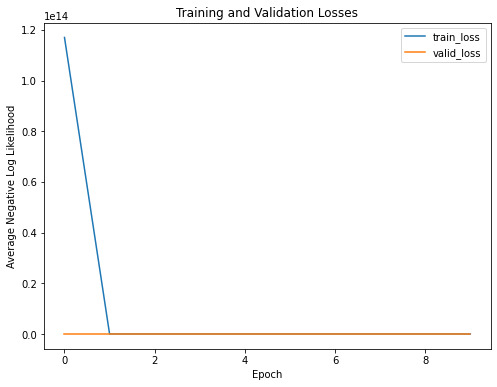

In [23]:

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

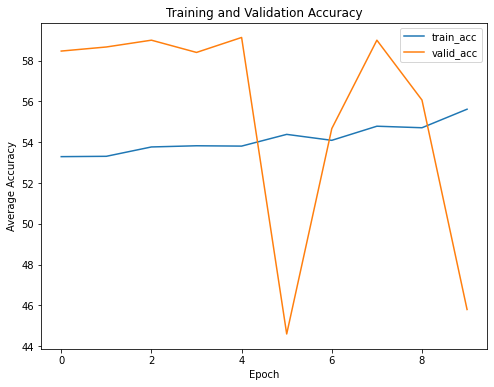

In [24]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [25]:
correct = 0
total = 0
device = torch.device("cuda")
vgg16.to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 46 %


In [26]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
vgg16.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for VGG on Train Data')

tensor([[3199., 1720.],
        [4621., 2460.]])


In [27]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
vgg16.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for VGG on validation Data')

tensor([[396., 219.],
        [574., 311.]])


In [28]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
vgg16.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for VGG on Test Data')

tensor([[412., 203.],
        [573., 312.]])


# Resnet Start here

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
resnet = models.resnet18(pretrained=True).to(device)
resnet.fc = nn.Sequential(
               nn.Linear(512, 770),
               nn.ReLU(inplace=True),
               nn.Linear(770, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
for param in resnet.parameters():
    param.requires_grad = True
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet.parameters(), lr=0.01, momentum=0.9)

In [0]:
model, history = corona(resnet, trainloader, validloader, 10, 'res18_entire.pth')

188it [03:25,  1.09s/it]
24it [00:18,  1.33it/s]

Epoch # 0 		Training loss:  0.25340732769604696 	 Validation loss:  0.24056779282788435
		Training Accuracy:  89.91666666666667 	 Validation Accuracy:  90.2



188it [03:19,  1.06s/it]
24it [00:17,  1.37it/s]

Epoch # 1 		Training loss:  0.18683700209998705 	 Validation loss:  0.22272913592557111
		Training Accuracy:  93.08333333333333 	 Validation Accuracy:  91.2



188it [03:18,  1.06s/it]
24it [00:17,  1.38it/s]

Epoch # 2 		Training loss:  0.1698268329962454 	 Validation loss:  0.23038828186690807
		Training Accuracy:  93.60000000000001 	 Validation Accuracy:  91.33333333333333



188it [03:18,  1.05s/it]
24it [00:17,  1.39it/s]

Epoch # 3 		Training loss:  0.15450883765724746 	 Validation loss:  0.23015815392136574
		Training Accuracy:  94.125 	 Validation Accuracy:  91.06666666666666



188it [03:18,  1.06s/it]
24it [00:17,  1.37it/s]

Epoch # 4 		Training loss:  0.14581653887921192 	 Validation loss:  0.20514854323118925
		Training Accuracy:  94.60833333333333 	 Validation Accuracy:  92.06666666666666



188it [03:18,  1.06s/it]
24it [00:17,  1.38it/s]

Epoch # 5 		Training loss:  0.14315626928780942 	 Validation loss:  0.2186365875725945
		Training Accuracy:  94.75 	 Validation Accuracy:  90.66666666666666



188it [03:19,  1.06s/it]
24it [00:17,  1.40it/s]

Epoch # 6 		Training loss:  0.13698163842584224 	 Validation loss:  0.21224135408798853
		Training Accuracy:  94.95 	 Validation Accuracy:  92.26666666666667



188it [03:18,  1.06s/it]
24it [00:17,  1.36it/s]

Epoch # 7 		Training loss:  0.13275235512868522 	 Validation loss:  0.21779107116162777
		Training Accuracy:  95.00833333333333 	 Validation Accuracy:  92.0



188it [03:18,  1.06s/it]
24it [00:17,  1.38it/s]

Epoch # 8 		Training loss:  0.1245303735473847 	 Validation loss:  0.2270640196899573
		Training Accuracy:  95.46666666666667 	 Validation Accuracy:  91.26666666666667



188it [03:17,  1.05s/it]
24it [00:17,  1.39it/s]


Epoch # 9 		Training loss:  0.1168946027953891 	 Validation loss:  0.22721742341915765
		Training Accuracy:  95.65833333333333 	 Validation Accuracy:  91.73333333333333


Text(0.5, 1.0, 'Training and Validation Losses')

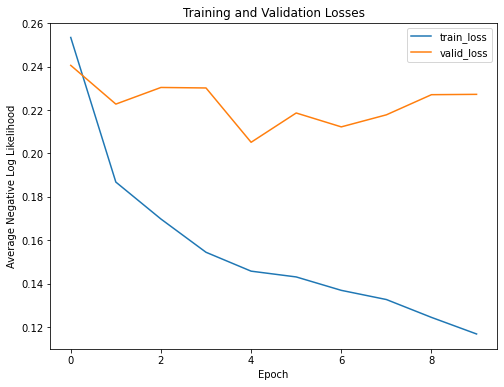

In [0]:

plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

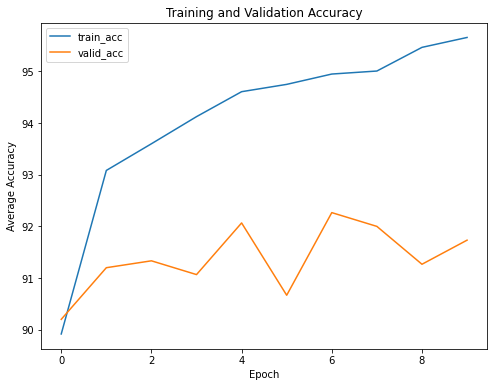

In [0]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [0]:
correct = 0
total = 0
device = torch.device("cuda")
resnet.to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96 %


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
resnet.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for Resnet on train Data')

tensor([[4557.,  362.],
        [ 124., 6957.]])


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
resnet.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for Resnet on validation Data')

tensor([[522.,  93.],
        [ 34., 851.]])


In [0]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
device = torch.device("cuda")
resnet.to(device)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix, show_absolute=True, show_normed=True, colorbar=True)
plt.title('Training Matrix for Resnet on test Data')

tensor([[567.,  48.],
        [  5., 880.]])
